<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=6> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=5> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=8> Phyton_kriging </font>
</div>
<div align="center"> 
<font size=6> kriging 2D with variogram 2D </font>
</div>

- **Fecha**: 2023/07/17
        
- **Objetivos**: 2D standard Kriging  using variogram 2D or radial, not 1D
- **Descripción** Tutorial for determining how it works

- **Autores**: 
    - Luis Miguel Sánchez Brea

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [3]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 160
rcParams['lines.markersize']=10
rcParams['image.cmap']='hot'
rcParams['figure.figsize']=(8,8)

%matplotlib inline


# Theoretical variogram 



In [4]:
import ipywidgets as widgets

In [5]:
from phyton_kriging import np, plt, degrees

from phyton_kriging.variogram_2D import theoretical
from phyton_kriging.standard_2D import kriging2D

## 2D variogram

In [6]:
%matplotlib inline

2023-08-07 13:52:06,937 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


name = gauss

hx: min - 0.0, max - 10.0
hx: min - 0.0, max - 10.0
variogram: min - 1.0, max - 1.9999999979388465
parameters = {'sc': 1, 'A': 1, 'lc': (5, 2.5), 'angle': 0.0, 'power': None}



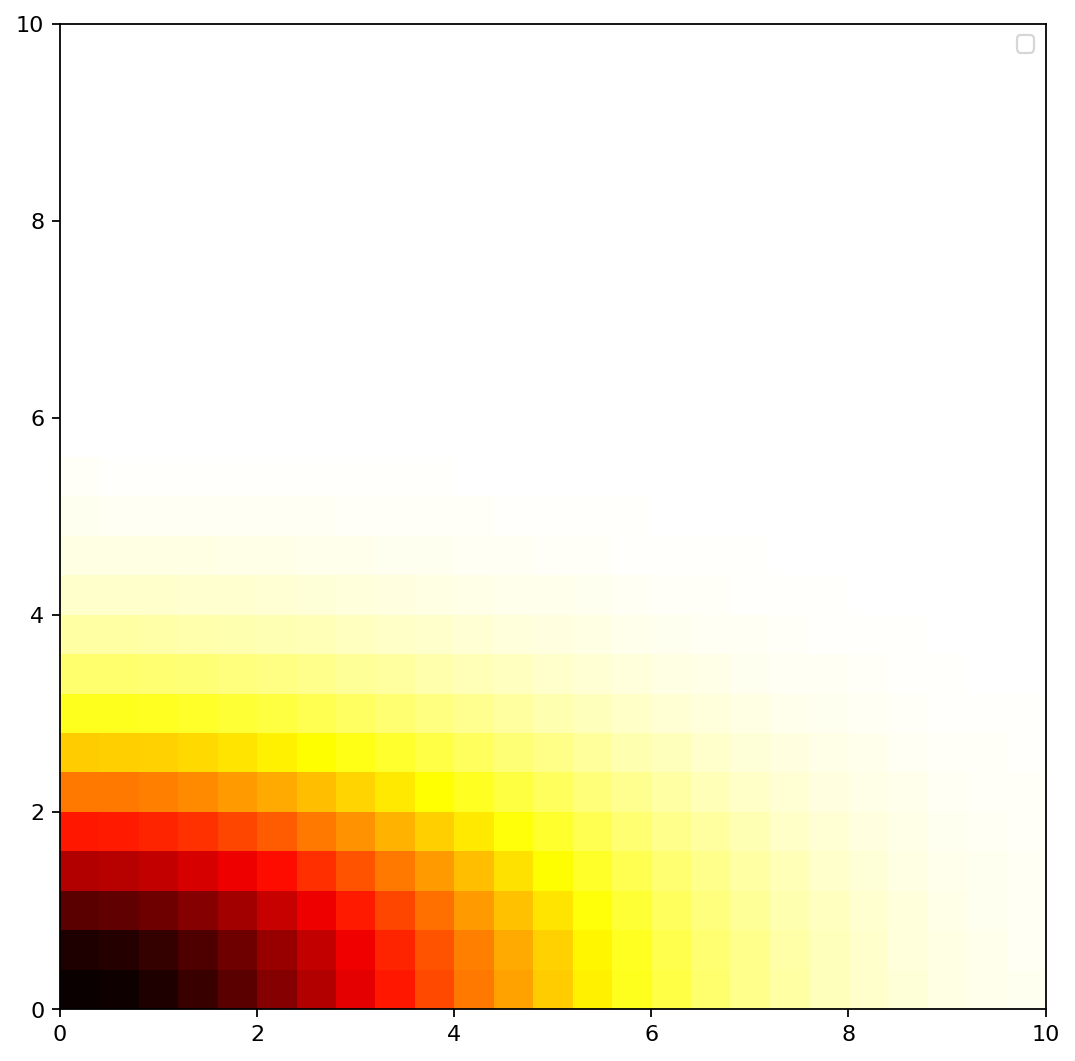

In [7]:
hx = np.linspace(0, 10, 25)
hy = np.linspace(0, 10, 25)
Hx, Hy = np.meshgrid(hx, hy)
H1 = (Hx, Hy)

# hx = np.random.uniform(0, 10, 512)
# hy = np.random.uniform(0, 10, 512)
H5 = (hx, hy)


var_theo = theoretical(H1, make_2D=True)
var_theo.gauss(sc=1, A=1, lc=(5, 2.5), angle=0 * degrees)
var_theo.draw2()
print(var_theo)

In [8]:
def f_signal(x, y, sc=0, I0=0):
    """Simulation of data

    Args:
        x (np.array): x_positions
        y (np.array): y_positions
        sc (float or np.array): random noise
        I0 (float or np.array): detector precision

    Returns:
        y (np.array): data.
    """
    num_sensors = len(x)

    z = x+y
    z = np.exp(-(x**2/(2*2.5**2)+y**2/(2*1.25**2)))
    z = np.sin(2 * np.pi * x / 20) * np.sin(2 * np.pi * y / 10)+x/20
    z = z + sc * np.random.randn(num_sensors)
    z = z + 2 * I0 * (np.random.rand(num_sensors) - 0.5)

    return z

In [9]:
sc=0.5
I0=0.25

num_x = num_y = 15
num_sensors = num_x * num_y

sensors = np.zeros((num_sensors, 4), dtype=float)

x = -10 + 20 * np.random.rand(num_sensors)
y = -10 + 20 * np.random.rand(num_sensors)

x = np.linspace(-10, 10, num_x)
y = np.linspace(-10, 10, num_y)

X,Y=np.meshgrid(x,y)
x = X.flatten()
y= Y.flatten()


sensors[:, 0] = x
sensors[:, 1] = y
sensors[:, 2] = f_signal(x,y,sc,I0)
sensors[:, 3] = sc * np.ones_like(x)

sensors[:, 2] = sensors[:, 2] + sensors[:, 3] * np.random.randn(num_sensors)


In [10]:
num_sampling = 60**2
num_x = num_y = int(np.sqrt(num_sampling))
x_sampling = np.linspace(-10, 10, num_x)
y_sampling = np.linspace(-10, 10, num_y)


X_sampling, Y_sampling = np.meshgrid(x_sampling,y_sampling)
sampling2D = (x_sampling, y_sampling)
z_ideal_sampling = f_signal(X_sampling, Y_sampling, 0, 0)
Sampling2D = (X_sampling, Y_sampling)

In [11]:
krig1 = kriging2D(sensors=sensors, variogram=var_theo, sampling=sampling2D)
krig1.ideal = z_ideal_sampling

In [12]:
def standard_new(self, filtering=True):
    """Standard kriging

    Args:
        * filtering: Si true se aplica la operacion LM para poder filtrar (tesis y articulo de AO)
                    Si False segun libros standard de kriging

    Outputs:
        * estimation
        * error
        * lambdas
    """

    xsensors = self.sensors[:, 0]
    ysensors = self.sensors[:, 1]
    data = self.sensors[:, 2]
    I = self.sensors[:, 3]

    Xsampling, Ysampling = self.Sampling
    Xsampling_size = len(Xsampling)
    Ysampling_size = len(Ysampling)

    xsampling = Xsampling.flatten()
    ysampling = Ysampling.flatten()

    XS1, XS2 = np.meshgrid(xsensors, xsensors)
    XS, XM = np.meshgrid(xsampling, xsensors)

    YS1, YS2 = np.meshgrid(ysensors, ysensors)
    YS, YM = np.meshgrid(ysampling, ysensors)

    # distance entre sensors
    distSensores = np.sqrt((XS2 - XS1)**2 + (YS2 - YS1)**2)
    distSensores_X = np.abs(XS2 - XS1)
    distSensores_Y = np.abs(YS2 - YS1)
    # distances entre sensors y points de sampling
    distSensoresMuestreo = np.sqrt((XS - XM)**2 + (YS - YM)**2)
    distSensoresMuestreo_X = np.abs(XS - XM)
    distSensoresMuestreo_Y = np.abs(YS - YM)

    # matrices principales
    
    Gamma = np.mat(self.variogram.get((distSensores_X, distSensores_Y)))
    print(distSensores_X)
    print(distSensores_Y)

    gamma = np.mat(
        self.variogram.get((distSensoresMuestreo_X, distSensoresMuestreo_Y)))

    # Modificaciones LM según artículo AO
    if filtering == True:
        s0 = self.variogram.get((0.,0.))
        I1, I2 = np.meshgrid(I, I)

        gamma = gamma - s0 / 2
        Gamma = Gamma - I1 * I2
        for i in range(len(xsensors)):
            Gamma[i, i] = -I[i]**2
    else:
        for i in range(len(xsensors)):
            Gamma[i, i] = 0

    # definición de matrices
    U = np.mat(np.ones((len(xsensors), 1), dtype='float'))
    u = np.mat(np.ones((len(xsampling), 1), dtype='float'))
    Ut = np.transpose(U)
    ut = np.transpose(u)
    invGamma = Gamma.I

    g = (ut - Ut * invGamma * gamma)
    h = (Ut * invGamma * U).I
    lambdas = np.mat(np.transpose(gamma + U * h * g) * invGamma)

    error2 = np.squeeze(
        np.diag(
            np.transpose(gamma) * invGamma * gamma -
            np.transpose(g) * h * g))
    print(error2)
    plt.figure()
    plt.imshow(error2.reshape(60,60))
    plt.colorbar()
    self.error = np.array(np.sqrt(error2))
    self.estimation = np.squeeze(
        np.array(lambdas * np.transpose(np.mat(data))))

    self.error = np.transpose(
        self.error.reshape(Xsampling_size, Ysampling_size))
    self.estimation = np.transpose(
        self.estimation.reshape(Xsampling_size, Ysampling_size))

    lambdas = np.array(lambdas)

    self.lambdas = lambdas.reshape(
        (Xsampling_size, Ysampling_size, len(xsensors)))

    return self


In [52]:
print(var_theo)

name = gauss

hx: min - 0.0, max - 10.0
hx: min - 0.0, max - 10.0
variogram: min - 1.0, max - 1.0
parameters = {'sc': 1, 'A': 1, 'lc': (5, 2.5), 'angle': 0.0, 'power': None}



In [34]:
hx=np.linspace(0,5,10)
hy=np.linspace(0,5,10)

Hx, Hy = np.meshgrid(hx, hy)

H = (Hx, Hy)


In [35]:
print(var_theo.get(h=H))
print("_"*50,"\n")
print(var_theo.variogram)

[[1.     1.0123 1.0482 1.1052 1.1792 1.2656 1.3588 1.4539 1.5462 1.6321]
 [1.0482 1.0599 1.094  1.1483 1.2188 1.3009 1.3897 1.4802 1.5681 1.6498]
 [1.1792 1.1893 1.2188 1.2656 1.3264 1.3972 1.4737 1.5518 1.6276 1.6981]
 [1.3588 1.3667 1.3897 1.4262 1.4737 1.5291 1.5889 1.6498 1.709  1.7641]
 [1.5462 1.5518 1.5681 1.5939 1.6276 1.6667 1.709  1.7522 1.7941 1.8331]
 [1.709  1.7126 1.7231 1.7396 1.7612 1.7863 1.8134 1.8411 1.868  1.893 ]
 [1.831  1.8331 1.8391 1.8488 1.8613 1.8759 1.8916 1.9077 1.9233 1.9378]
 [1.9111 1.9121 1.9153 1.9204 1.927  1.9347 1.943  1.9514 1.9596 1.9673]
 [1.9576 1.9581 1.9596 1.9621 1.9652 1.9689 1.9728 1.9768 1.9808 1.9844]
 [1.9817 1.9819 1.9826 1.9836 1.985  1.9865 1.9883 1.99   1.9917 1.9933]]
__________________________________________________ 

[[1.     1.0123 1.0482 1.1052 1.1792 1.2656 1.3588 1.4539 1.5462 1.6321]
 [1.0482 1.0599 1.094  1.1483 1.2188 1.3009 1.3897 1.4802 1.5681 1.6498]
 [1.1792 1.1893 1.2188 1.2656 1.3264 1.3972 1.4737 1.5518 1.6276 1.698

In [36]:
print(krig1.variogram)

name = gauss

hx: min - 0.0, max - 10.0
hx: min - 0.0, max - 10.0
variogram: min - 1.0, max - 1.9932620530009144
parameters = {'sc': 1, 'A': 1, 'lc': (5, 2.5), 'angle': 0.0, 'power': None}



In [47]:
hs = np.array([2,1])
print(hs)
print(krig1.variogram.get(hs))

[2 1]
1.273850962926309


[[ 0.      1.4286  2.8571 ... 17.1429 18.5714 20.    ]
 [ 1.4286  0.      1.4286 ... 15.7143 17.1429 18.5714]
 [ 2.8571  1.4286  0.     ... 14.2857 15.7143 17.1429]
 ...
 [17.1429 15.7143 14.2857 ...  0.      1.4286  2.8571]
 [18.5714 17.1429 15.7143 ...  1.4286  0.      1.4286]
 [20.     18.5714 17.1429 ...  2.8571  1.4286  0.    ]]
[[ 0.  0.  0. ... 20. 20. 20.]
 [ 0.  0.  0. ... 20. 20. 20.]
 [ 0.  0.  0. ... 20. 20. 20.]
 ...
 [20. 20. 20. ...  0.  0.  0.]
 [20. 20. 20. ...  0.  0.  0.]
 [20. 20. 20. ...  0.  0.  0.]]
[0.5476 0.5198 0.4977 ... 0.4977 0.5198 0.5476]


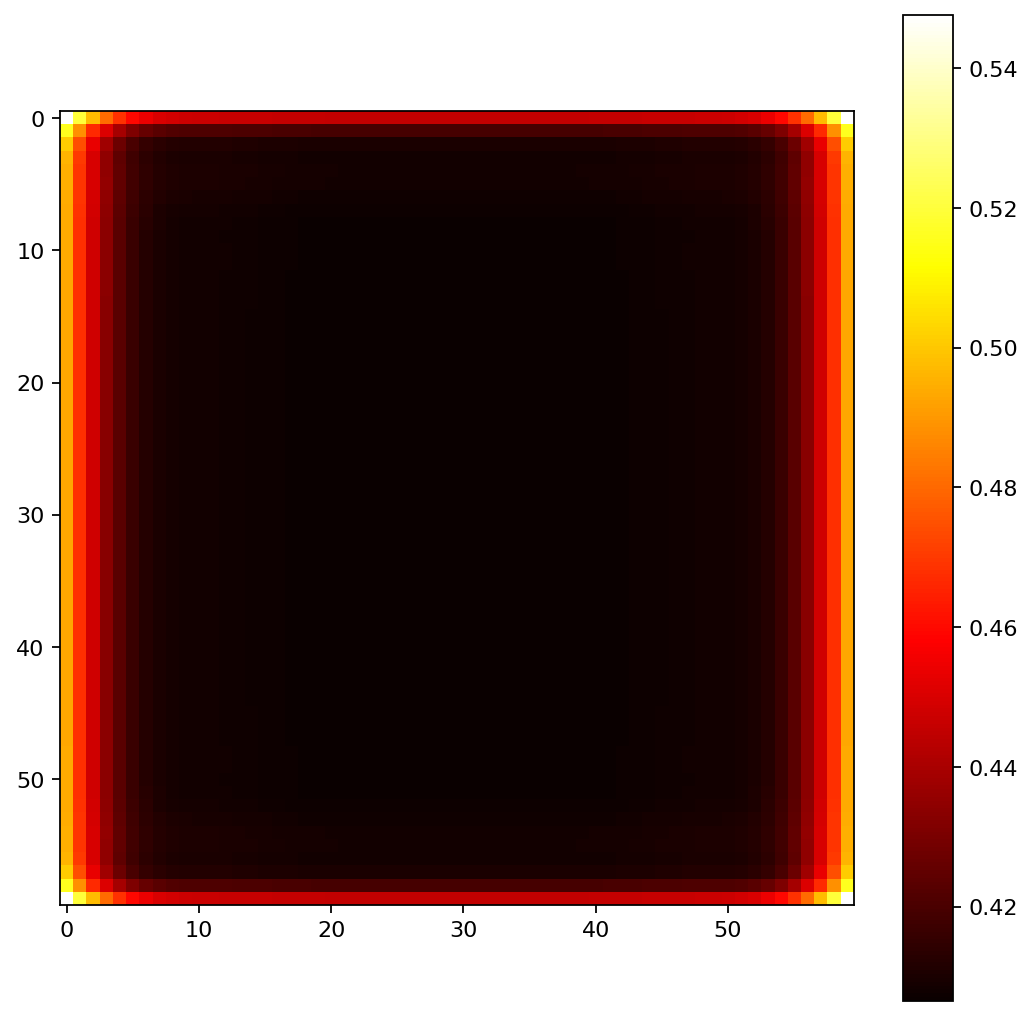

In [13]:
krg1 = standard_new(krig1)


In [39]:
# krig1.krigStandard2D_no_uniforme()

In [40]:
print(krig1.estimation.shape)
print(krig1.error.shape)
print(krig1.lambdas.shape)
print(z_ideal_sampling.shape)

(60, 60)
(60, 60)
(60, 60, 225)
(60, 60)


## Drawings

c:\Program Files\Python311\Lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


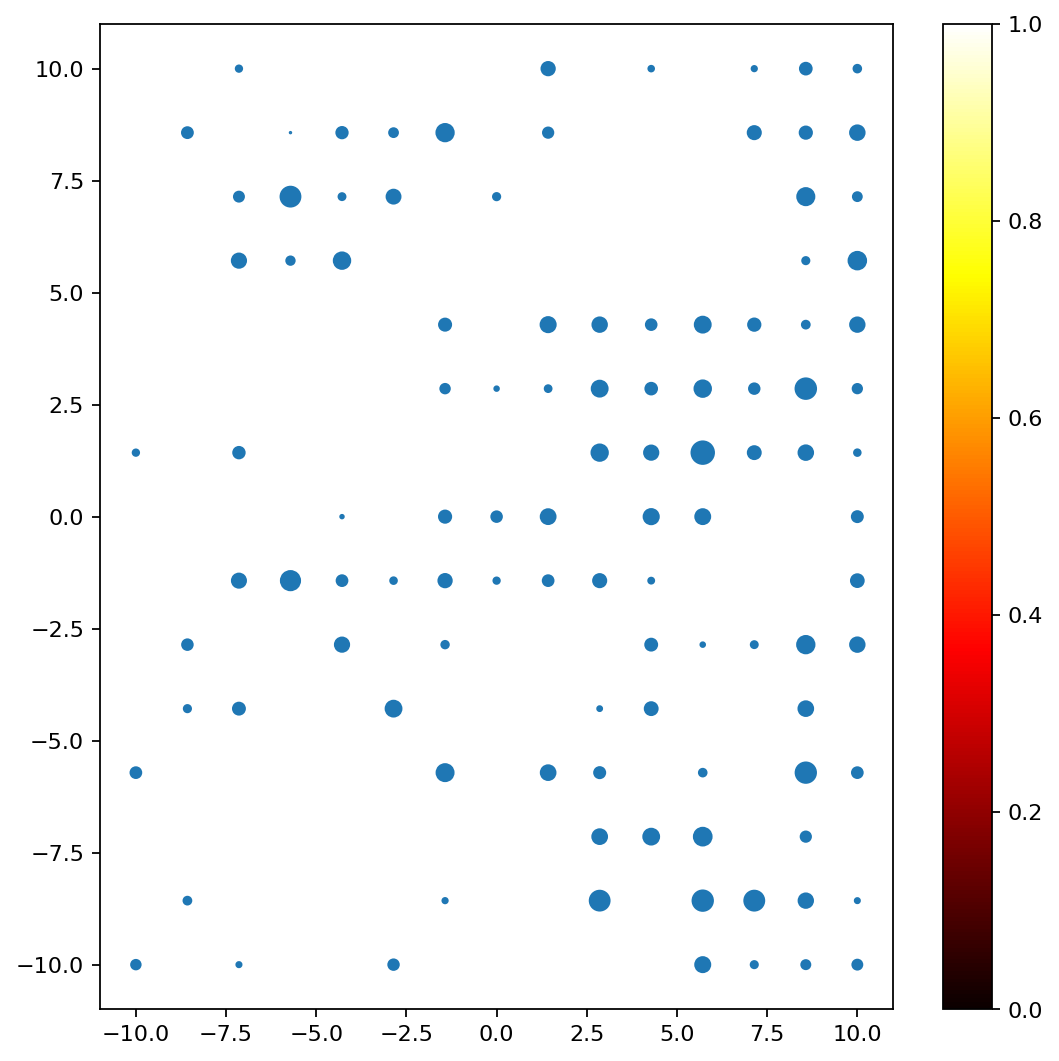

In [41]:
krig1.draw('data')

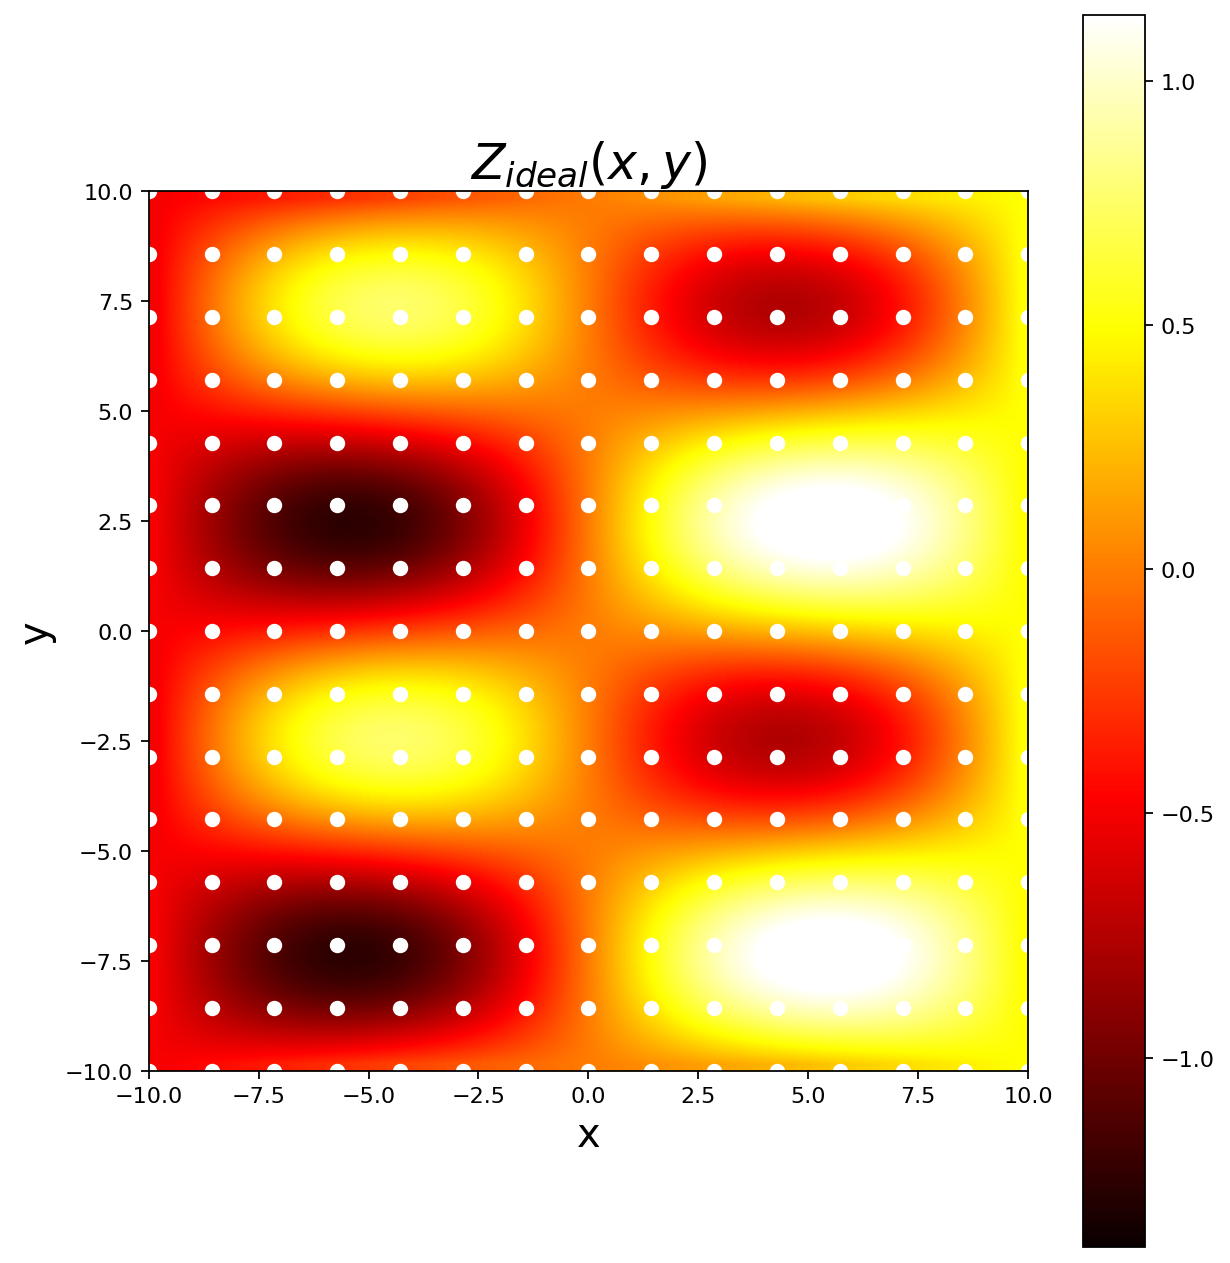

In [42]:
krig1.draw('ideal')

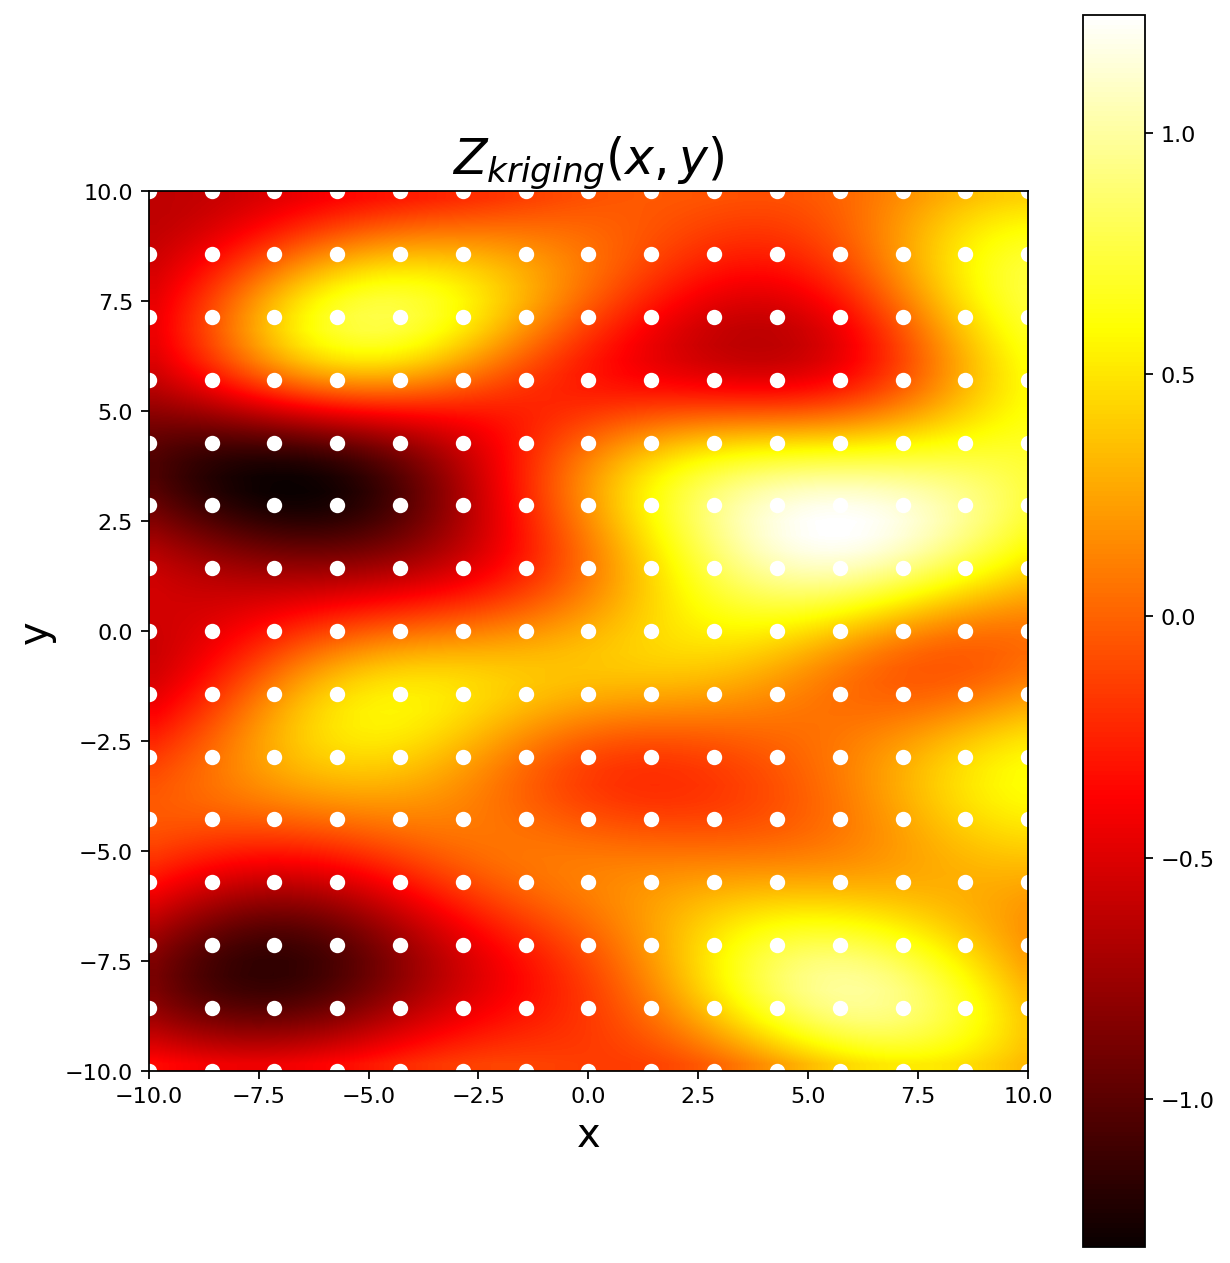

In [43]:
krig1.draw('kriging')

In [44]:
krig1.variogram.draw()

(25, 25) (25, 25)
()


IndexError: invalid index to scalar variable.

In [ ]:
krig1.draw('error')


NameError: name 'krig1' is not defined

In [ ]:
print(krig1.error.min(), krig1.error.max())
print(krig1.error.mean(), krig1.error.std())


NameError: name 'krig1' is not defined

In [ ]:
%matplotlib widget
krig1.draw('lambdas')


NameError: name 'krig1' is not defined

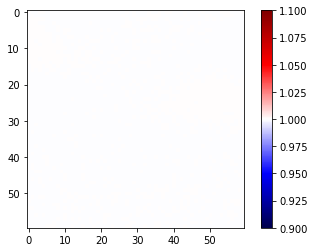

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(krig1.lambdas.sum(axis=2), cmap='seismic')
plt.colorbar()
plt.clim(0.9, 1.1)